In [33]:
# Load the best model from pth file type

import torch
import torch.optim as optim
import numpy as np
import wandb
import os
import multiprocessing
import matplotlib.pyplot as plt

# add path
import sys
sys.path.append(r'c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN')
sys.path.append(r'c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN\postnet')

from postnet.LoadDataset_class import load_Moons, load_MNIST, load_CIFAR
from postnet.PosteriorNetwork_class import NormalisingFlow, AffineCouplingLayer, Conditioner, PosteriorNetwork
from postnet.Learning_scheduler import GradualWarmupScheduler, train, init_weights
from postnet.evaluate import evaluate_model, image_show, plot_loss_acc, plot_entropy # computes test metrics

models = ['PostNet'] #['PostNet', 'Ensemble']
m = 0 # indexing for the different models
dataset_name = ['Moons', 'MNIST', 'CIFAR10'] #['CIFAR10']  #  

#for Moons, MNIST, CIFAR respectively
latent_dim = [2, 10, 6] 
num_flows = [6,6,6] # number of coupling flow layers
#training_lr = [1e-4, 1e-4, 1e-4] # start of training (end of warmup ) #Note: High LR create NaNs and Inf 
#num_epochs = [1000, 200, 200] 
#reg = [1e-5, 1e-5, 1e-5] # entropy regularisation 

warmup_steps= [1000, 1000, 1000] # batch size is larger for CIFAR10 so more steps
validation_every_steps = 50 
early_stop_patience = 20 # so after n-validations without improvement, stop training
early_stop_delta = 0.001 #in procent this is 0.1% 

num_classes = [2, 10, 10]
start_lr = 1e-9 # start of warmup
weight_decay = 1e-5  # L2 regularization strength to prevent overfitting in Adam or AdamW 
batch_size = [64,64,64]

num_params = 2 # s and t
num_hidden = [2, 3, 3] # number of hidden layers
hidden_dim = [32, 64, 64] # neurons in hidden layers
#annealing_interval = 150 # Every 10 epochs, anneal LR (warm restart)
#min_lr = 1e-6 # during cosine annealing
split = lambda x: x.chunk(2, dim=-1)

subset_percentage = 1
split_ratios = [0.6, 0.8]

seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
#wandb.login(key="dbe998ec8ce0708b96bb4f34fb31951d9c0eb25f")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

num_epochs = [500, 300, 300]
num_flows = [6] #4, 6 8, 10, 20      
training_lr = [1e-3, 1e-4, 1e-5] # 5e-5 
reg = [1e-4, 1e-5, 0] #[1e-3, 1e-4] 

# run 7/12/02:28
# num_epochs = [350, 100, 100]
# num_flows = [6] 
# training_lr = [1e-3, 1e-4, 1e-5] 
# reg = [1e-4, 1e-5, 0] 
num_epochs = [500, 300, 300]
num_flows = [6] #4, 6 8, 10, 20      
training_lr = [1e-4] # 5e-5 
reg = [1e-4] 

i=0 # Moons
fl = 0
lr = 0
r = 0
loaders, N_counts, set_lengths, ood_dataset_loaders, N_ood = load_Moons(batch_size[i], n_samples=3000, noise=0.1, split_ratios=split_ratios, seed=seed)
flow_models = []
for class_label in range(num_classes[i]):
    conditioner = Conditioner(in_dim=latent_dim[i]//2, out_dim=latent_dim[i]//2, num_hidden=num_hidden[i], hidden_dim=hidden_dim[i], num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split, latent_dim[i])
    flows = [affine_coupling for _ in range(num_flows[fl])]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(latent_dim[i]).to(device), scale_tril=torch.eye(latent_dim[i]).to(device))
    flow_model = NormalisingFlow(latent_distribution, flows).to(device)
    #flow_model = NormalisingFlow(latent_distribution, flows).apply(init_weights).to(device) #Prevents learning???
    flow_models.append(flow_model)
#postnet_model = PosteriorNetwork(latent_dim[i], flow_models, N_counts['train'], num_classes[i], reg[r], dataset_name[i]).apply(init_weights).to(device)
best_model = PosteriorNetwork(latent_dim[i], flow_models, N_counts['train'], num_classes[i], reg[r], dataset_name[i]).to(device)

optimiser = optim.AdamW(best_model.parameters(), lr=training_lr[lr], weight_decay=weight_decay)
warmup_scheduler = GradualWarmupScheduler(optimiser, warmup_steps=warmup_steps[i], start_lr=start_lr, end_lr=training_lr[lr])
#training_scheduler = optim.lr_scheduler.ConstantLR
training_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimiser, gamma=0.995)

model_name = 'PostNet_Reg0.0001_LR0.0001_Flows6_Warm1000_Epoch500_Wdecay1e-05_HidD32_hLay2_LD2'
current_wd = os.getcwd()
root_dir = os.path.dirname(current_wd)
print(root_dir)
#plots_dir = os.path.join(root_dir, 'saved_plots')
#save_model = os.path.join(root_dir, 'saved_models', dataset_name, model_name + '.pth')
save_model = os.path.join(root_dir, 'Grid_search', 'moons_best', model_name + '.pth')
checkpoint = torch.load(save_model)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()

#val_metrics, entropy_data = evaluate_model(postnet_model, loaders['val'], ood_dataset_loaders['val'], N_counts['val'], N_ood['val'], dataset_name[i], model_name, device)
X_train = loaders['train'].dataset.tensors[0]
y_train = loaders['train'].dataset.tensors[1]
latent_train_data = best_model.cnn(X_train.to(device)).cpu().detach().numpy()


c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN\notebooks
Device:  cuda
c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN


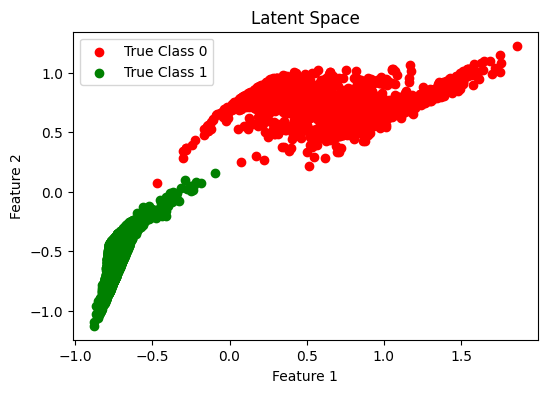

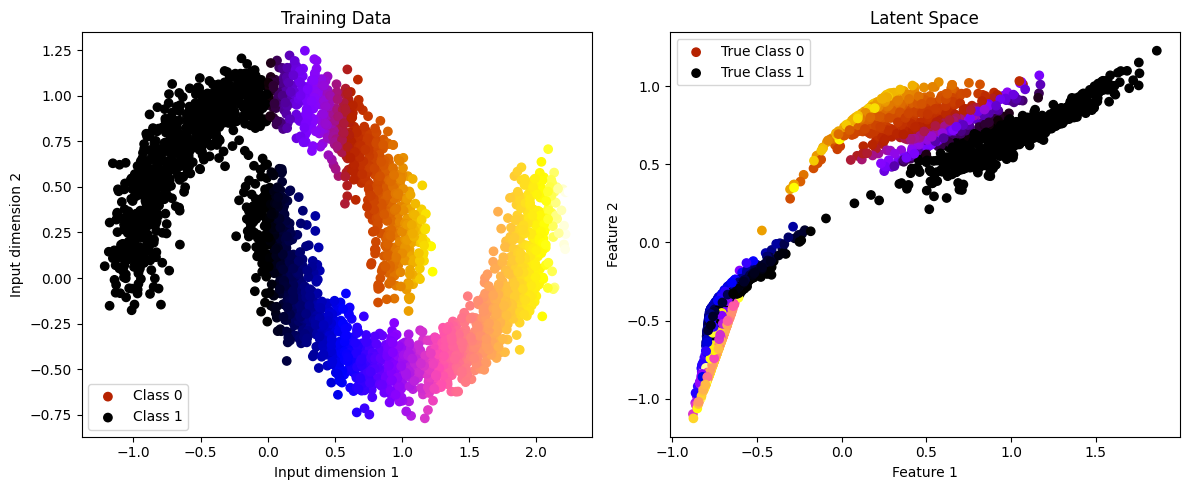

In [34]:

plt.figure(figsize=(6,4))
plt.scatter(latent_train_data[y_train == 0][:, 0], latent_train_data[y_train == 0][:, 1], c='red', label='True Class 0', marker='o')
plt.scatter(latent_train_data[y_train == 1][:, 0], latent_train_data[y_train == 1][:, 1], c='green', label='True Class 1', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Latent Space')
plt.legend(loc='upper left')
plt.show()

#Plot med outlier og bestemte punkter highlighted. Evt bruge regnbue farver. Husk punkt 5 imellem de to klasser. Out of distribution – aleatorisk usikkerhed. 
#  Brug AU-ROC curve til at se thresholds for ood data.
# use X_train and colour them rainbow based on x1 value
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot training data
rainbow_colors_c0 = plt.get_cmap('gnuplot')(X_train[y_train == 0][:, 0] / X_train[y_train == 0][:, 0].max()) #rainbow, ocean
rainbow_colors_c1 = plt.get_cmap('gnuplot2')(X_train[y_train == 1][:, 0] / X_train[y_train == 1][:, 0].max())

# axes[0].scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], c='red', label='Class 0')
# axes[0].scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], c='green', label='Class 1')
axes[0].scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], c=rainbow_colors_c0, label='Class 0')
axes[0].scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], c=rainbow_colors_c1, label='Class 1')
axes[0].set_xlabel('Input dimension 1')
axes[0].set_ylabel('Input dimension 2')
axes[0].legend(loc='lower left', frameon=True, labelcolor='black')  # Adjust legend properties
axes[0].set_title('Training Data')

# plot the latent space datapoints and see how they changed
axes[1].scatter(latent_train_data[y_train == 0][:, 0], latent_train_data[y_train == 0][:, 1], c=rainbow_colors_c0, label='True Class 0', marker='o')
axes[1].scatter(latent_train_data[y_train == 1][:, 0], latent_train_data[y_train == 1][:, 1], c=rainbow_colors_c1, label='True Class 1', marker='o')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend(loc='upper left')
axes[1].set_title('Latent Space')
plt.tight_layout()
plt.show()

In [35]:
num_classes = 2
# Plot the meshgrid of the learned latent space
# Create a meshgrid in the latent space
coords = 3.8
denseness = 700
nx, ny = (denseness, denseness)
x = np.linspace(-coords, coords, nx)
y = np.linspace(-coords, coords, ny)
xv, yv = np.meshgrid(x, y)
mesh = np.stack((xv.flatten(), yv.flatten()), axis=1)
mesh_tensor = torch.FloatTensor(mesh).to(device)

# Run the train data through only the CNN using the best_model.pt
#latent_train_data = best_model.cnn(X_train.to(device)).cpu().detach().numpy()
# Run a meshgrid of datapoints through encoder (and then through flow) to get logprobs
latent_mesh = best_model.cnn(mesh_tensor.to(device))



In [36]:
num_samples = 1000
samples, posterior_samples, generated_samples = [], [], []
# Compute log-probabilities for each class
logprobs, logprobs_mesh = [], []
for i in range(num_classes):
    log_prob = flow_models[i].log_prob(mesh_tensor).clamp(min=-10, max=10)
    logprobs.append(log_prob.cpu().reshape((nx, ny)).detach().numpy())
    # run latent_mesh through flow to get logprobs
    log_prob_mesh = flow_models[i].log_prob(latent_mesh).clamp(min=-10, max=10)
    logprobs_mesh.append(log_prob_mesh.cpu().reshape((nx, ny)).detach().numpy())

    # Get samples in the latent space
    samples.append(best_model.flow_models[i].sample(num_samples).to(device)) #self.g(self.latent_sample(num_samples))
    # Sample from the posterior distribution using the NormalisingFlow object
    post = best_model.flow_models[i].latent_sample(num_samples).to(device)
    posterior_samples.append(post)    


# Show what the normalising flow has learned
plt.figure(figsize=(6, 4))
plt.imshow(np.exp(logprobs_mesh[0]), extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', alpha=1)
plt.imshow(np.exp(logprobs_mesh[1]), extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar(label='Probability Density')
plt.xlabel('Input Dimension 1')
plt.ylabel('Input Dimension 2')
plt.title('Before Encoder Combined Probability Density for Both Classes')
plt.show()

#Grid er datapunkter – køre gennem encoder – og så gennem flow og regne logprobs og plot der
# BEFORE encoder plot the logprobs_mesh as heatmaps for each class
colors = ['red', 'green']
plt.figure(figsize=(12,4))
for class_label in range(num_classes):
    plt.subplot(1, num_classes, class_label + 1)
    plt.imshow(np.exp(logprobs_mesh[class_label]), extent=[-coords, coords, -coords, coords], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.scatter(X_train[y_train == class_label][:, 0], X_train[y_train == class_label][:, 1],
                c=colors[class_label], alpha=0.07, label=f'True Class {class_label}')
    plt.xlabel('Input Dimension 1')
    plt.ylabel('Input Dimension 2')
    plt.legend(loc='upper left')
    plt.title(f'Before encoder Class {class_label} Probability Density map with Train Data ') 
plt.tight_layout()
plt.show()

# AFTER encoder Plot the log probabilities as heatmaps for each class
colors = ['red', 'red']
plt.figure(figsize=(12,4))
for class_label in range(num_classes):
    plt.subplot(1, num_classes, class_label + 1)
    plt.imshow(np.exp(logprobs[class_label]), extent=[-coords, coords, -coords, coords], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.scatter(latent_train_data[y_train == class_label][:, 0], latent_train_data[y_train == class_label][:, 1],
                c=colors[class_label], alpha=0.07, label=f'True Class {class_label}')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend(loc='upper left')
    plt.title(f'After encoder Class {class_label} Probability Density with Train Data')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
for class_label in range(num_classes):
    plt.subplot(1, num_classes, class_label + 1)
    plt.imshow(np.exp(logprobs[class_label]), extent=[-coords, coords, -coords, coords], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.scatter(samples[class_label][:, 0].numpy(), samples[class_label][:, 1].numpy(), 
                c=colors[class_label],s=10, alpha=0.07, label=f'Generated Class {class_label}')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend(loc='upper left')
    plt.title(f'Class {class_label} Probability Density with Generated \nSamples from the normalising flow')
plt.tight_layout()
plt.show()

# Plot the log probabilities for both classes in the same plot
plt.figure(figsize=(8, 6))
plt.imshow(np.exp(logprobs[0]), extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', alpha=1)
plt.imshow(np.exp(logprobs[1]), extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar(label='Probability Density')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Combined Probability Density for Both Classes')
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 6.00 GiB total capacity; 5.28 GiB already allocated; 0 bytes free; 5.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

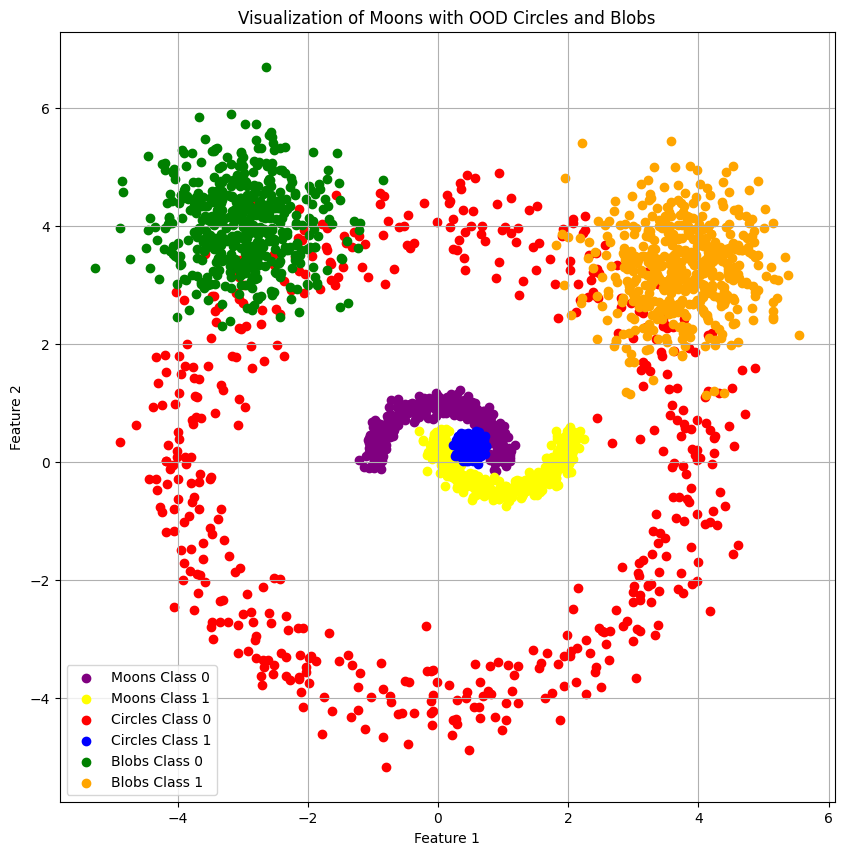

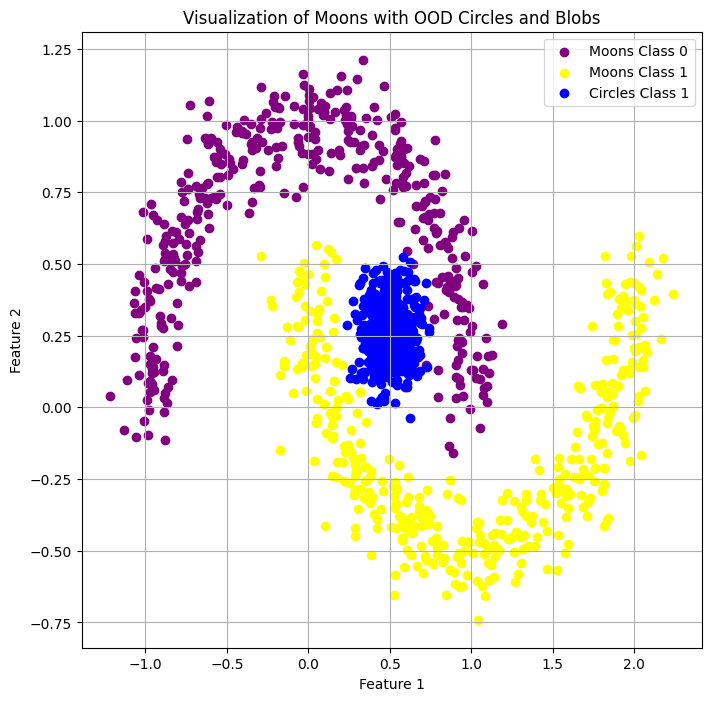

In [ ]:
import torch
from sklearn.datasets import make_circles, make_blobs, make_moons
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
#train_test_split
import matplotlib.pyplot as plt
n_samples = 1000
noise = 0.01
seed = 42
batch_size= 32

big_circle_radius = 4
small_circle_radius = 0.23
factor = 0.1
#small_circle_radius / big_circle_radius
outer_noise = 0.1
inner_noise = 0.4

# X_c, y_c = make_circles(n_samples=n_samples, noise=noise, factor=factor, random_state=seed) # inner circle is 10% radius of outer circle
# outer_circle_noise = np.random.normal(scale=outer_noise, size=X_c[y_c == 0].shape)
# inner_circle_noise = np.random.normal(scale=inner_noise, size=X_c[y_c == 1].shape)
# X_c[y_c == 0] += outer_circle_noise
# X_c[y_c == 1] += inner_circle_noise
# # scale the circles to specific radius
# X_c[y_c == 0] *= big_circle_radius
# X_c[y_c == 1] *= small_circle_radius
# # translate
# X_c[y_c == 1] += [0.5,0.25]

X_c, y_c = make_circles(n_samples=n_samples, noise=0.01, factor=0.1, random_state=seed)
outer_circle_noise = np.random.normal(scale=0.1, size=X_c[y_c == 0].shape) 
inner_circle_noise = np.random.normal(scale=0.4, size=X_c[y_c == 1].shape) 
X_c[y_c == 0] += outer_circle_noise # Add custom noise to outer circle
X_c[y_c == 1] += inner_circle_noise
X_c[y_c == 0] *= 4  # Scale big circle radius
X_c[y_c == 1] *= 0.23  # Scale small circle radius
X_c[y_c == 1] += [0.5, 0.25]  # Translate small circle to center
X_c = torch.tensor(X_c, dtype=torch.float32)
y_c = torch.tensor(y_c, dtype=torch.long)
circ_dataset = TensorDataset(X_c, y_c)
circ_loader = DataLoader(circ_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
X_circ = X_c.numpy()
y_circ = y_c.numpy()

X_b, y_b = make_blobs(n_samples=n_samples, centers=[[-3,4],[3.7,3.2]], n_features=2, cluster_std=0.7, random_state=seed)
X_b = torch.tensor(X_b, dtype=torch.float32)
y_b = torch.tensor(y_b, dtype=torch.long)
blob_dataset = TensorDataset(X_b, y_b)
blod_loader = DataLoader(blob_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
X_blob = X_b.numpy()
y_blob = y_b.numpy()

X_moons, y_moons = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=42)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
X_train_numpy = X_train_tensor.numpy()
y_train_numpy = y_train_tensor.numpy()


# Plotting
plt.figure(figsize=(10, 10))
# Plot make_moons data
plt.scatter(X_train_numpy[y_train_numpy == 0][:, 0], X_train_numpy[y_train_numpy == 0][:, 1], alpha=1,color='purple', label='Moons Class 0')
plt.scatter(X_train_numpy[y_train_numpy == 1][:, 0], X_train_numpy[y_train_numpy == 1][:, 1], alpha=1, color='yellow', label='Moons Class 1')
# Plot make_circles data
plt.scatter(X_circ[y_circ == 0][:, 0], X_circ[y_circ == 0][:, 1], color='red', label='Circles Class 0')
plt.scatter(X_circ[y_circ == 1][:, 0], X_circ[y_circ == 1][:, 1], color='blue', label='Circles Class 1')
# Plot make_blobs data
plt.scatter(X_blob[y_blob == 0][:, 0], X_blob[y_blob == 0][:, 1], color='green', label='Blobs Class 0')
plt.scatter(X_blob[y_blob == 1][:, 0], X_blob[y_blob == 1][:, 1], color='orange', label='Blobs Class 1')
plt.title('Visualization of Moons with OOD Circles and Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
# Plot make_moons data
plt.scatter(X_train_numpy[y_train_numpy == 0][:, 0], X_train_numpy[y_train_numpy == 0][:, 1], alpha=1,color='purple', label='Moons Class 0')
plt.scatter(X_train_numpy[y_train_numpy == 1][:, 0], X_train_numpy[y_train_numpy == 1][:, 1], alpha=1, color='yellow', label='Moons Class 1')
# Plot make_circles data
#plt.scatter(X_circ[y_circ == 0][:, 0], X_circ[y_circ == 0][:, 1], color='red', label='Circles Class 0')
plt.scatter(X_circ[y_circ == 1][:, 0], X_circ[y_circ == 1][:, 1], color='blue', label='Circles Class 1')
# Plot make_blobs data
#plt.scatter(X_blob[y_blob == 0][:, 0], X_blob[y_blob == 0][:, 1], color='green', label='Blobs Class 0')
#plt.scatter(X_blob[y_blob == 1][:, 0], X_blob[y_blob == 1][:, 1], color='orange', label='Blobs Class 1')
plt.title('Visualization of Moons with OOD Circles and Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


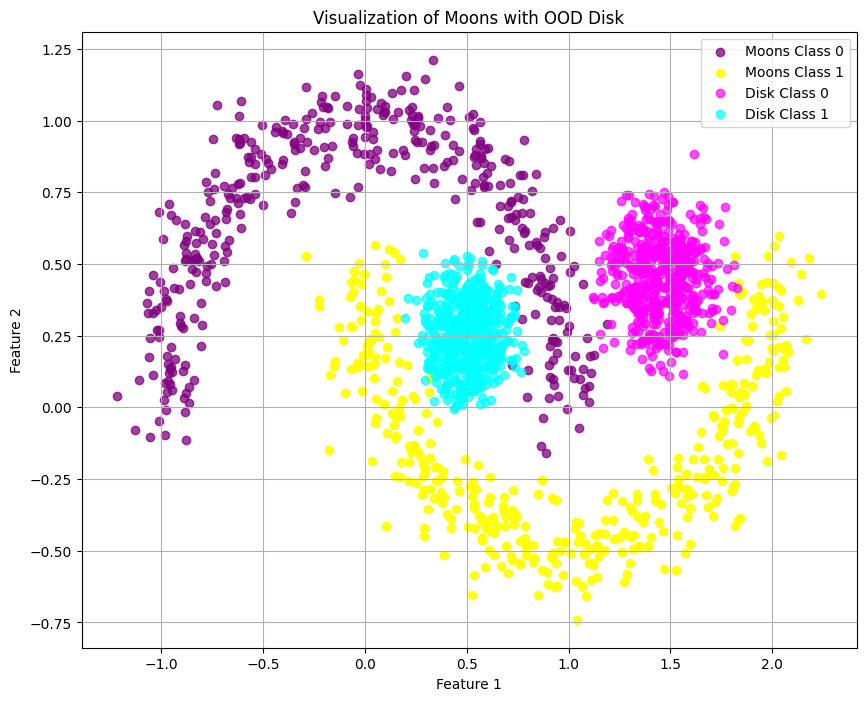

"plt.figure(figsize=(10, 10))\n# Plot make_moons data\nplt.scatter(X_train_numpy[y_train_numpy == 0][:, 0], X_train_numpy[y_train_numpy == 0][:, 1], alpha=1,color='purple', label='Moons Class 0')\nplt.scatter(X_train_numpy[y_train_numpy == 1][:, 0], X_train_numpy[y_train_numpy == 1][:, 1], alpha=1, color='yellow', label='Moons Class 1')\n# Plot make_circles data\nplt.scatter(X_circ[y_circ == 0][:, 0], X_circ[y_circ == 0][:, 1], color='red', label='Circles Class 0')\nplt.scatter(X_circ[y_circ == 1][:, 0], X_circ[y_circ == 1][:, 1], color='blue', label='Circles Class 1')\n# Plot make_blobs data\nplt.scatter(X_blob[y_blob == 0][:, 0], X_blob[y_blob == 0][:, 1], color='green', label='Blobs Class 0')\nplt.scatter(X_blob[y_blob == 1][:, 0], X_blob[y_blob == 1][:, 1], color='orange', label='Blobs Class 1')\nplt.title('Visualization of Moons with OOD Circles and Blobs')\nplt.xlabel('Feature 1')\nplt.ylabel('Feature 2')\nplt.legend()\nplt.grid(True)\nplt.show()"

In [5]:
import numpy as np
import torch
from sklearn.datasets import make_circles, make_blobs, make_moons
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
#train_test_split
import matplotlib.pyplot as plt
n_samples = 1000
noise = 0.01
seed = 42
#set seed
torch.manual_seed(seed)
np.random.seed(seed)
batch_size= 32

# big_circle_radius = 4
# small_circle_radius = 0.23
# factor = 0.1
# #small_circle_radius / big_circle_radius
# outer_noise = 0.1
# inner_noise = 0.4

X_b, y_b = make_blobs(n_samples=n_samples, centers=[[-3,4],[3.7,3.2]], n_features=2, cluster_std=0.7, random_state=seed)
X_b = torch.tensor(X_b, dtype=torch.float32)
y_b = torch.tensor(y_b, dtype=torch.long)
blob_dataset = TensorDataset(X_b, y_b)
blod_loader = DataLoader(blob_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
X_blob = X_b.numpy()
y_blob = y_b.numpy()

X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=seed)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
X_train_numpy = X_train_tensor.numpy()
y_train_numpy = y_train_tensor.numpy()


# # Circles
# X_c, y_c = make_circles(n_samples=n_samples, noise=0.01, factor=0.1, random_state=seed)
# outer_circle_noise = np.random.normal(scale=0.1, size=X_c[y_c == 0].shape) 
# inner_circle_noise = np.random.normal(scale=0.4, size=X_c[y_c == 1].shape) 
# X_c[y_c == 0] += outer_circle_noise # Add custom noise to outer circle
# X_c[y_c == 1] += inner_circle_noise
# X_c[y_c == 0] *= 4  # Scale big circle radius
# X_c[y_c == 1] *= 0.23  # Scale small circle radius
# X_c[y_c == 1] += [0.5, 0.25]  # Translate small circle to center
# X_c = torch.tensor(X_c, dtype=torch.float32)
# y_c = torch.tensor(y_c, dtype=torch.long)
# circ_dataset = TensorDataset(X_c, y_c)
# circ_loader = DataLoader(circ_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
# X_circ = X_c.numpy()
# y_circ = y_c.numpy()

# DISK DATASET
X_c, y_c = make_circles(n_samples=n_samples, noise=0.01, factor=0.8, random_state=seed)
outer_circle_noise = np.random.normal(scale=0.6, size=X_c[y_c == 0].shape) # add seed 
inner_circle_noise = np.random.normal(scale=0.5, size=X_c[y_c == 1].shape) 
X_c[y_c == 0] += outer_circle_noise # Add custom noise to outer circle
X_c[y_c == 1] += inner_circle_noise
X_c[y_c == 0] *= 0.15 # Scale big circle radius
X_c[y_c == 1] *= 0.15  # Scale small circle radius
X_c[y_c == 0] += [1.45, 0.45]  # Translate larger circle to center
X_c[y_c == 1] += [0.5, 0.25]  # Translate small circle to center
X_c = torch.tensor(X_c, dtype=torch.float32)
y_c = torch.tensor(y_c, dtype=torch.long)
circ_dataset = TensorDataset(X_c, y_c)
circ_loader = DataLoader(circ_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
X_circ = X_c.numpy()
y_circ = y_c.numpy()

# Plotting
plt.figure(figsize=(10, 8))
# Plot make_moons data
plt.scatter(X_train_numpy[y_train_numpy == 0][:, 0], X_train_numpy[y_train_numpy == 0][:, 1], alpha=0.75,color='purple', label='Moons Class 0')
plt.scatter(X_train_numpy[y_train_numpy == 1][:, 0], X_train_numpy[y_train_numpy == 1][:, 1], alpha=0.9, color='yellow', label='Moons Class 1')
# Plot make_circles data
#plt.scatter(X_circ[y_circ == 0][:, 0], X_circ[y_circ == 0][:, 1], alpha=0.7, color='red', label='Circles Class 0')
#plt.scatter(X_circ[y_circ == 1][:, 0], X_circ[y_circ == 1][:, 1], alpha=0.7, color='blue', label='Circles Class 1')
# Plot Disk data
plt.scatter(X_circ[y_circ == 0][:, 0], X_circ[y_circ == 0][:, 1], alpha=0.7, color='magenta', label='Disk Class 0')
plt.scatter(X_circ[y_circ == 1][:, 0], X_circ[y_circ == 1][:, 1], alpha=0.7, color='cyan', label='Disk Class 1')
# Plot make_blobs data
#plt.scatter(X_blob[y_blob == 0][:, 0], X_blob[y_blob == 0][:, 1], alpha=0.8, color='green', label='Blobs Class 0')
#plt.scatter(X_blob[y_blob == 1][:, 0], X_blob[y_blob == 1][:, 1], alpha=0.8, color='orange', label='Blobs Class 1')


plt.title('Visualization of Moons with OOD Disk')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

"""plt.figure(figsize=(10, 10))
# Plot make_moons data
plt.scatter(X_train_numpy[y_train_numpy == 0][:, 0], X_train_numpy[y_train_numpy == 0][:, 1], alpha=1,color='purple', label='Moons Class 0')
plt.scatter(X_train_numpy[y_train_numpy == 1][:, 0], X_train_numpy[y_train_numpy == 1][:, 1], alpha=1, color='yellow', label='Moons Class 1')
# Plot make_circles data
plt.scatter(X_circ[y_circ == 0][:, 0], X_circ[y_circ == 0][:, 1], color='red', label='Circles Class 0')
plt.scatter(X_circ[y_circ == 1][:, 0], X_circ[y_circ == 1][:, 1], color='blue', label='Circles Class 1')
# Plot make_blobs data
plt.scatter(X_blob[y_blob == 0][:, 0], X_blob[y_blob == 0][:, 1], color='green', label='Blobs Class 0')
plt.scatter(X_blob[y_blob == 1][:, 0], X_blob[y_blob == 1][:, 1], color='orange', label='Blobs Class 1')
plt.title('Visualization of Moons with OOD Circles and Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()"""


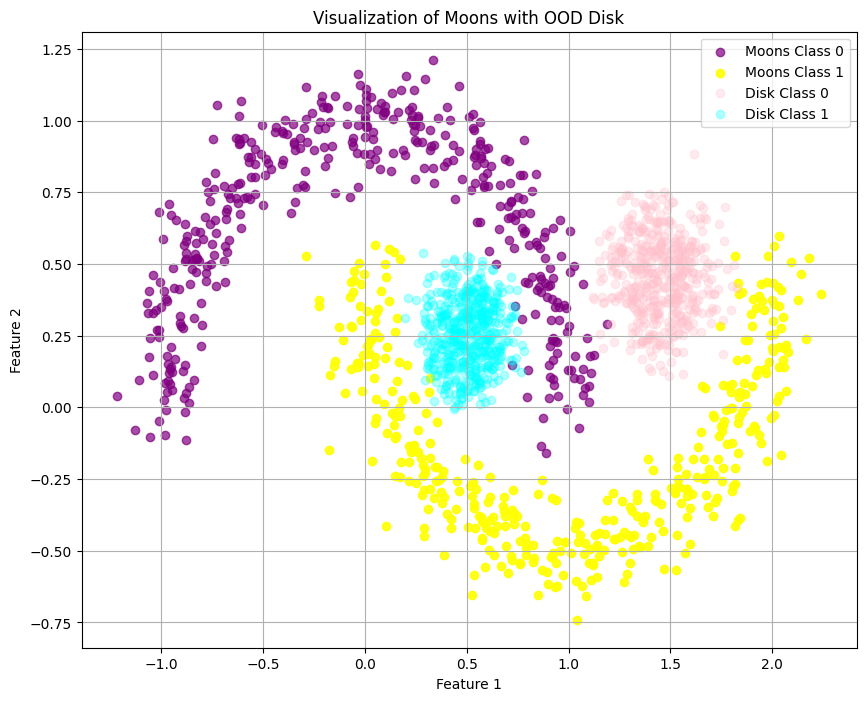

In [39]:


plt.figure(figsize=(10, 8))
# Plot make_moons data
plt.scatter(X_train_numpy[y_train_numpy == 0][:, 0], X_train_numpy[y_train_numpy == 0][:, 1], alpha=0.7,color='purple', label='Moons Class 0')
plt.scatter(X_train_numpy[y_train_numpy == 1][:, 0], X_train_numpy[y_train_numpy == 1][:, 1], alpha=0.9, color='yellow', label='Moons Class 1')
# Plot make_circles data
plt.scatter(X_circ[y_circ == 0][:, 0], X_circ[y_circ == 0][:, 1], alpha=0.3, color='pink', label='Disk Class 0')
plt.scatter(X_circ[y_circ == 1][:, 0], X_circ[y_circ == 1][:, 1], alpha=0.3, color='cyan', label='Disk Class 1')
# Plot make_blobs data
#plt.scatter(X_blob[y_blob == 0][:, 0], X_blob[y_blob == 0][:, 1], color='green', label='Blobs Class 0')
#plt.scatter(X_blob[y_blob == 1][:, 0], X_blob[y_blob == 1][:, 1], color='orange', label='Blobs Class 1')


plt.title('Visualization of Moons with OOD Disk')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
batch_size = [64,64,64]
i=1
from postnet.LoadDataset_class import load_Moons, load_MNIST, load_CIFAR
loaders, N_counts, set_lengths, ood_dataset_loaders, N_ood = load_MNIST(batch_size[i], subset_percentage=None, split_ratios=split_ratios, seed=seed)            

In [57]:
# Load KMNIST dataset and plot a random sample from each class
print(ood_dataset_loaders['val']['KMNIST'].dataset.classes)
print(ood_dataset_loaders['val']['FashionMNIST'].dataset.classes)



['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


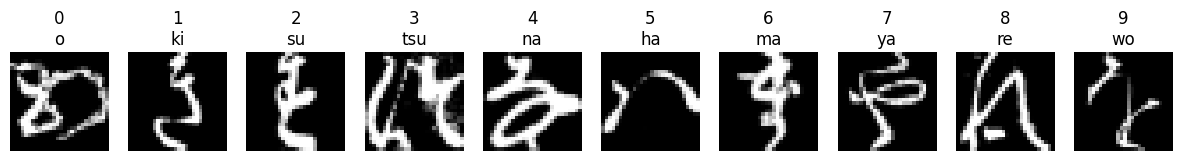

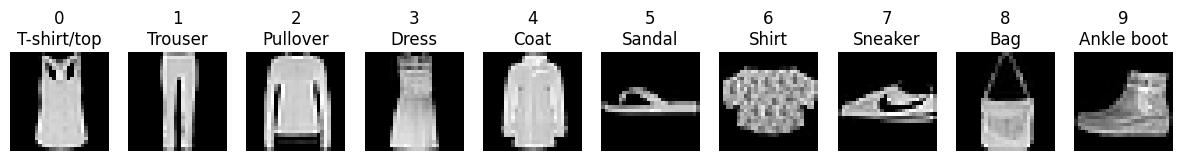

In [63]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch

# Find a sample image from each class
def plot_samples(loader, title):
    class_images = {}
    for images, labels in loader:
        for image, label in zip(images, labels):
            label = label.item()
            if label not in class_images:
                class_images[label] = image
            if len(class_images) == 10:  # All classes found
                break
        if len(class_images) == 10:
            break

    # Plot the images
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    #fig.suptitle(title)
    for i in range(10):
        ax = axes[i]
        ax.imshow(class_images[i].numpy().squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'{i}\n{loader.dataset.classes[i]}')
    plt.show()

# Plot random samples from each class
plot_samples(ood_dataset_loaders['val']['KMNIST'], 'KMNIST - Sample Images by Class')
plot_samples(ood_dataset_loaders['val']['FashionMNIST'], 'FashionMNIST - Sample Images by Class')


In [68]:
from torchvision import datasets, transforms
import seaborn as sns
loaders, N_counts, set_lengths, ood_dataset_loaders, N_ood = load_CIFAR(batch_size[i], subset_percentage=None, split_ratios=split_ratios, seed=seed) 

Files already downloaded and verified
Using downloaded and verified file: c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN\data\test_32x32.mat


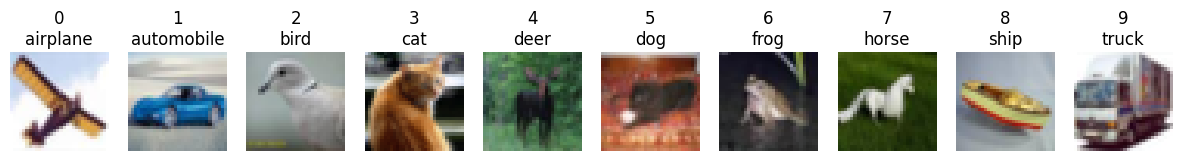

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

#transform_cifar = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
#transform_svhn = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)) ])

def unnormalize(img, dataset_name):
    # CIFAR-10 normalization parameters
    mean_cifar = (0.4914, 0.4822, 0.4465)
    std_cifar = (0.247, 0.243, 0.261)
    # SVHN normalization parameters
    mean_svhn = (0.4377, 0.4438, 0.4728)
    std_svhn = (0.1980, 0.2010, 0.1970)

    if dataset_name == 'CIFAR':
        for t, m, s in zip(img, mean_cifar, std_cifar):
            t.mul_(s).add_(m)
    elif dataset_name == 'SVHN':
        for t, m, s in zip(img, mean_svhn, std_svhn):
            t.mul_(s).add_(m)
    return img

def plot_random_samples_from_each_class(loader, dataset_name):
    class_images = {}
    for images, labels in loader:
        for image, label in zip(images, labels):
            label = label.item()
            if label not in class_images:
                class_images[label] = image
            if len(class_images) == 10:  # All classes found
                break
        if len(class_images) == 10:
            break

    # Plot the images
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    for i, ax in enumerate(axes):
        image_show(ax, class_images[i], dataset_name)
        ax.set_title(f'{i}\n{loader.dataset.classes[i]}')
    plt.show()

# Make sure to define the `image_show` function as before
def image_show(ax, img, dataset_name):
    img = img.detach().cpu()
    img = unnormalize(img, dataset_name)  # Ensure you have defined the unnormalize function
    ax.imshow(img.permute((1, 2, 0)).numpy())
    ax.axis('off')

# Example usage
plot_random_samples_from_each_class(loaders['val'], 'CIFAR')



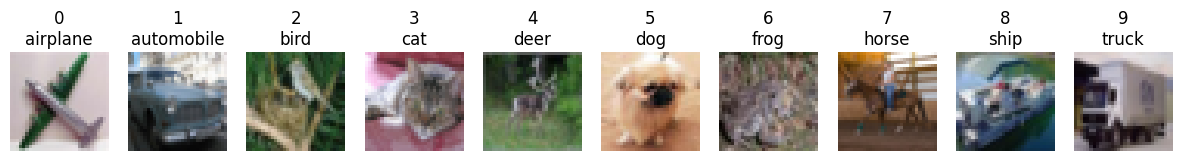

In [86]:
plot_random_samples_from_each_class(loaders['val'], 'CIFAR')

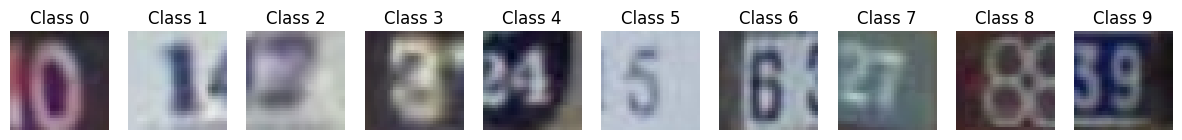

In [101]:
def plot_random_samples_from_each_class(loader, dataset_name):
    class_images = {}
    class_names = [str(i) for i in range(10)]  # Class names are the digits 0-9

    for images, labels in loader:
        for image, label in zip(images, labels):
            label = label.item()
            if label not in class_images:
                class_images[label] = image
            if len(class_images) == 10:  # All classes found
                break
        if len(class_images) == 10:
            break

    # Plot the images
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    for i, ax in enumerate(axes):
        image_show(ax, class_images[i], dataset_name)
        ax.set_title(f'Class {i}')
        #ax.set_title(f'{i}\n{class_names[i]}')  # Use class_names for the title
    plt.show()
plot_random_samples_from_each_class(ood_dataset_loaders['val']['SVHN'], 'SVHN')

In [91]:
# Print length of SVHN
print(len(ood_dataset_loaders['val']['SVHN'].dataset))
# Print number of samples
print(len(ood_dataset_loaders['val']['SVHN'].dataset.data))
# Print number of labels
print(len(ood_dataset_loaders['val']['SVHN'].dataset.labels))
# Print number of classes
print(len(ood_dataset_loaders['val']['SVHN'].dataset.classes))

26032
26032
26032


AttributeError: 'SVHN' object has no attribute 'classes'